<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/SQF_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
mini_train_ratios = train_ratios[0:50]
mini_test_ratios = test_ratios[0:50]

In [0]:
#need to change this to create windows for all stocks 

def split_data(n_days, data): #data for one stock in the form [days, bins]
  no_ts = data.shape[0]-n_days
  length_ts = n_days*data.shape[1]
  new_data = np.zeros((no_ts,length_ts))
  for j in range(no_ts):
    for i in range(n_days): 
      new_data[j,64*i:64*i + 64] = data[j+i,:]
  
  return new_data

In [0]:
def make_test_data(train_data, test_data, n_days, stock_index):
  all_data = np.concatenate((train_data, test_data), axis = 1)
  
  one_data = all_data[stock_index]
  
  #now want to take only sets of n_days which contain the test data too 
  no_ts = test_data.shape[1]
  length_ts = n_days*one_data.shape[1]
  new_data = np.zeros((no_ts, length_ts))
  
  for j in range(no_ts): 
    for i in range(n_days): 
      new_data[j, 64*i:64*i + 64] = one_data[train_data.shape[1]+j-180+i+1,:]
      
  return new_data


testing_ratios = make_test_data(train_ratios, test_ratios, 180, 0)

In [0]:
def getbd_from_theta(theta): 
  gamma, beta, delta = theta
  
  L = len(beta)
  
  b = torch.zeros(L)
  for l in range(L): 
    if l == 0 : 
      b[l] = beta[l]
    else: 
      b[l] = beta[l]-beta[l-1]
  d = torch.zeros(L)
  for l in range(1,L): 
    d[l] = torch.sum(delta[:l])
    
  return b, d

In [0]:
def crps_loss(theta, z):
  gamma, beta, delta = theta
  
  L = len(beta)
  
  b, d = getbd_from_theta(theta)
  
  lo = 0 
    
  for l in range(L-1, -1, -1): 
    val = sqf(theta, d[l])
    if val < z:
      lo = l
      break 
  
  a_tilde = (z-gamma + torch.sum(b[:lo]*d[:lo]))/torch.sum(b[:lo+1])
  
  max_ = torch.max(torch.zeros(L)+a_tilde, d)
  #print('max', max_)
  
  bracket = (1/3)*(1-torch.pow(d, 3)) - d - torch.pow(max_,2) + 2*max_*d
  #print('bracket', bracket)
  
  loss = (2*a_tilde - 1)*z + (1-2*a_tilde)*gamma + torch.sum(b*bracket)
  #print(loss.item())
  
  return loss 

In [0]:
def sqf(theta, quantile): 
  
  #would expect beta and delta to be vectors length hidden_units
  
  gamma, beta, delta = theta
  L = len(beta)
  
  b,d = getbd_from_theta(theta)
    
  max_ = torch.max(quantile-d, torch.zeros(L))
  
  qf = gamma + torch.sum(b*max_)
  
  return qf

In [0]:
class Encoder(nn.Module): 
  
  def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.hidden_size)
    self.dense = nn.Linear(self.hidden_size, 1)
    self.softmax = nn.functional.softmax
    self.softplus = nn.functional.softplus
    
  def init_hidden(self): 
    return torch.zeros(self.num_layers, 1, self.hidden_size)
  
  def forward(self, data, hidden):
    lstm_out, hidden = self.lstm(data.view(1, 1, -1))
    fc_layer = self.linear(lstm_out.view(-1)) 
    delta = self.softmax(fc_layer)
    beta = self.softmax(fc_layer)
    gamma = self.dense(fc_layer)
    
    theta = (gamma, beta, delta)
    #print('theta', theta)
    #print('delta', delta)
    #print('beta', beta)
    
    return theta, hidden 
  

In [0]:
learning_rate = 0.0005
#learning_rate_decay = 
num_epochs = 15
T = 3*64
num_paths = 50
pred_length = 64
num_lstm_layers = 2
hidden_units = 80
batch_size = 10

training_data = split_data(int(T/64), train_ratios[0])
training_data.shape

small_data = np.zeros((10, training_data.shape[1]))
for i in range(small_data.shape[0]): 
  index = np.random.randint(0, training_data.shape[0])
  small_data[i,:] = training_data[index]
  
small_data_new = torch.FloatTensor(small_data)

In [96]:
encoder = Encoder(1, hidden_units, batch_size, 1, num_lstm_layers)
print(encoder)

Encoder(
  (lstm): LSTM(1, 80, num_layers=2)
  (linear): Linear(in_features=80, out_features=80, bias=True)
  (dense): Linear(in_features=80, out_features=1, bias=True)
)


In [99]:
### TRAINING the encoder###

##Question: should optimization be done on each time series or over loss for all TS?
loss_function = crps_loss
encoder_optimiser = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
train_loss = []

for i in range(num_epochs): 
  encoder.zero_grad()
  encoder_hidden = encoder.init_hidden()
  
  batch_loss = 0
  
  data_batch = small_data_new #change this when using larger dataset 
  
  for j in range(batch_size):
    loss_t = 0 
    input_data = data_batch[j]
    
    #print('training batch element', j)
    
    for t in range(T-1): 
      theta, encoder_hidden = encoder(input_data[t:t+1], encoder_hidden)
      loss_t += loss_function(theta, input_data[t+1:t+2])
 
      
    #ts_loss = loss_t  
    #print(ts_loss)
    
    #encoder_optimiser.zero_grad()
    #ts_loss.backward()
    #encoder_optimiser.step()
   
    batch_loss+= loss_t
    
  loss_batch = batch_loss 
    
  encoder_optimiser.zero_grad()
  
  batch_loss.backward()

  encoder_optimiser.step()

  train_loss.append(batch_loss.item())
  
  print("Epoch ", i, "CRPS ", batch_loss.item())
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 CRPS  1042.209716796875
Epoch  1 CRPS  825.5733032226562
Epoch  2 CRPS  636.6781616210938
Epoch  3 CRPS  475.8078308105469
Epoch  4 CRPS  343.047119140625
Epoch  5 CRPS  238.12265014648438
Epoch  6 CRPS  160.26931762695312
Epoch  7 CRPS  108.00437927246094
Epoch  8 CRPS  79.11420440673828
Epoch  9 CRPS  73.12834167480469
Epoch  10 CRPS  88.9939193725586
Epoch  11 CRPS  118.69500732421875


KeyboardInterrupt: ignored

tensor([889.9541], grad_fn=<AddBackward0>)

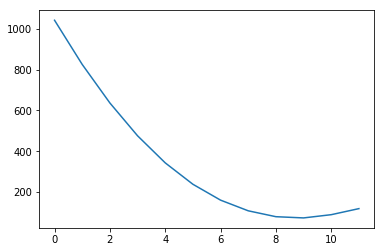

In [100]:
plt.plot(train_loss)

In [0]:
## PREDICTION ##
decoder = Encoder()

with torch.no_grad(): 
  for t in range(T): 
    theta, encoder_hidden = encoder(input_data[t], encoder_hidden)
    
  for n in range(num_paths): 
  
    decoder_input = input_data[T]
    decoder_hidden = encoder_hidden 
    alpha = torch.distributions.uniform.Uniform(0,1)
    sample_path = []

    for i in range(pred_length): 
      theta, decoder_hidden = decoder(decoder_input, decoder_hidden)
      z_hat = sqf(theta, alpha)
      sample_path.append(z_hat)
      decoder_input = z_hat
      
    path = input_data.append(sample_path)
